# INTRO

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install scikit-plot

from collections import defaultdict


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Preparation

rimuovo la data in quanto genera troppi campi binari non utili alla classificazione, troppa dimensionalità nel dataset

In [4]:
class_name = 'Occupancy'

dataset_path="/content/drive/Shared drives/DM2/files/rebalanced/ros.csv"
df = pd.read_csv(dataset_path)



del df['Date']
del df['CO2']
del df['Humidity']
del df['Light']
del df['Temperature']
del df['HumidityRatio']
del df['Hour']


df.head()



,Day,TimeSlot,Weekend,WorkingHour,Occupancy
0,2,2,0,1,1
1,2,2,0,1,1
2,2,2,0,1,1
3,2,2,0,1,1
4,2,2,0,1,1


In [0]:
def prepare_dataset(df, class_name):
    df = remove_missing_values(df)
    numeric_columns = get_numeric_columns(df)
    rdf = df.copy(deep=True)
    df, feature_names, class_values = one_hot_encoding(df, class_name)
    real_feature_names = get_real_feature_names(rdf, numeric_columns, class_name)
    rdf = rdf[real_feature_names + (class_values if isinstance(class_name, list) else [class_name])]
    features_map = get_features_map(feature_names, real_feature_names)

    return df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map

def remove_missing_values(df):
    for column_name, nbr_missing in df.isna().sum().to_dict().items():
        if nbr_missing > 0:
            if column_name in df._get_numeric_data().columns:
                mean = df[column_name].mean()
                df[column_name].fillna(mean, inplace=True)
            else:
                mode = df[column_name].mode().values[0]
                df[column_name].fillna(mode, inplace=True)
    return df

def get_numeric_columns(df):
    numeric_columns = list(df._get_numeric_data().columns)
    return numeric_columns

def get_real_feature_names(rdf, numeric_columns, class_name):
    real_feature_names = [c for c in rdf.columns if c in numeric_columns and c != class_name]
    real_feature_names += [c for c in rdf.columns if c not in numeric_columns and c != class_name]
    return real_feature_names

def one_hot_encoding(df, class_name):
    dfX = pd.get_dummies(df[[c for c in df.columns if c != class_name]], prefix_sep='=')
    class_name_map = {v: k for k, v in enumerate(sorted(df[class_name].unique()))}
    dfY = df[class_name].map(class_name_map)
    df = pd.concat([dfX, dfY], axis=1)
    feature_names = list(dfX.columns)
    class_values = sorted(class_name_map)
    return df, feature_names, class_values

def get_features_map(feature_names, real_feature_names):
    features_map = defaultdict(dict)
    i = 0
    j = 0

    while i < len(feature_names) and j < len(real_feature_names):
        if feature_names[i] == real_feature_names[j]:
            features_map[j][feature_names[i]] = j
            i += 1
            j += 1
        elif feature_names[i].startswith(real_feature_names[j]):
            features_map[j][feature_names[i]] = j
            i += 1
        else:
            j += 1
    return features_map

In [6]:
res = prepare_dataset(df, class_name)
df, feature_names, class_values, numeric_columns, rdf, real_feature_names, features_map = res
df.head()

,Day,TimeSlot,Weekend,WorkingHour,Occupancy
0,2,2,0,1,1
1,2,2,0,1,1
2,2,2,0,1,1
3,2,2,0,1,1
4,2,2,0,1,1


In [0]:
from sklearn.naive_bayes import GaussianNB, CategoricalNB

from sklearn.model_selection import train_test_split, cross_val_score 

from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.metrics import roc_curve, auc, roc_auc_score



attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

# CATEGORIAL BAYES UTILIZZO SOLO CAMPI CATEGORIALI RIMUOVO CONTINUI

In [0]:
#rdf[[c for c in rdf.columns if c not in numeric_columns]].head()

In [0]:
#from sklearn.preprocessing import LabelEncoder

#rdf_en = rdf[[c for c in rdf.columns if c not in numeric_columns]].apply(LabelEncoder().fit_transform)
#rdf_en.head()

considero adesso soltanto le variabili categoriali da utilizzare nel classificatore naive bayes categoriale (da rivedere questo dataset generato in quanto ha rimosso valori che dovrebbero servire)

In [0]:
#X_train_cat, X_test_cat, y_train, y_test = train_test_split(
#    rdf_en[[c for c in rdf_en.columns if c not in numeric_columns]], df[class_name], 
#       test_size=0.3, random_state=100, stratify=df[class_name])

In [11]:
clf = CategoricalNB()
clf.fit(X_train, y_train)

CategoricalNB(alpha=1.0, class_prior=None, fit_prior=True)

testo il classificatore categoriale sui nuovi dati considerati

In [12]:
y_pred = clf.predict(X_test)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.9537212734556189
F1-score [0.95254567 0.95484004]
              precision    recall  f1-score   support

           0       0.98      0.93      0.95      4743
           1       0.93      0.98      0.95      4743

    accuracy                           0.95      9486
   macro avg       0.95      0.95      0.95      9486
weighted avg       0.95      0.95      0.95      9486



effettuo la cross validation 

In [13]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.9552 (+/- 0.01)
F1-score: 0.9552 (+/- 0.01)


roc curve e lift chart del classificatore categoriale

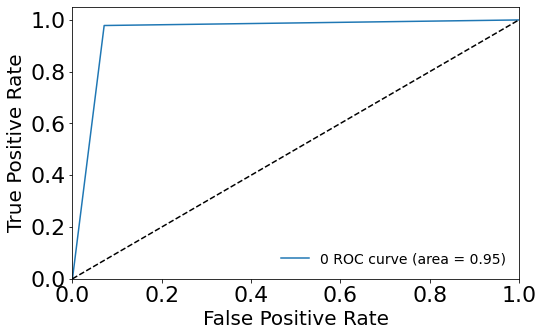

In [14]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)


for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()


lift chart categorical NB

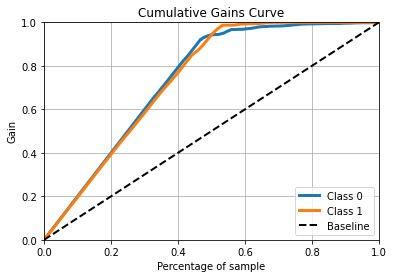

In [15]:
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB

#X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

clf = CategoricalNB()
clf.fit(X_train, y_train)

predicted_probas = clf.predict_proba(X_test)

# The magic happens here

import matplotlib.pyplot as plt

import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

plt.show()

#MULTINOMIAL BAYES DISCRETIZZO CAMPI CONTINUI IN BINS

In [16]:
df = pd.read_csv(dataset_path)
df.head()

,Date,Day,Hour,TimeSlot,Weekend,WorkingHour,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,2015-02-02 14:19:00,2,14:19,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
1,2015-02-02 14:19:00,2,14:19,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
2,2015-02-02 14:19:00,2,14:19,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
3,2015-02-02 14:19:00,2,14:19,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1
4,2015-02-02 14:19:00,2,14:19,2,0,1,15.904468,8.698835,7.516689,5.235582,10.795786,1


In [17]:
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.naive_bayes import MultinomialNB

del df['Date']
del df['Hour']

df['Temperature'] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(df.Temperature.values.reshape(-1,1))
df['Humidity'] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(df.Temperature.values.reshape(-1,1))
df['Light'] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(df.Temperature.values.reshape(-1,1))
df['CO2'] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(df.Temperature.values.reshape(-1,1))
df['HumidityRatio'] = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform').fit_transform(df.Temperature.values.reshape(-1,1))

print (df)


       Day  TimeSlot  Weekend  ...  CO2  HumidityRatio  Occupancy
0        2         2        0  ...  8.0            8.0          1
1        2         2        0  ...  8.0            8.0          1
2        2         2        0  ...  8.0            8.0          1
3        2         2        0  ...  8.0            8.0          1
4        2         2        0  ...  8.0            8.0          1
...    ...       ...      ...  ...  ...            ...        ...
31615   18         1        0  ...  3.0            3.0          1
31616   18         1        0  ...  3.0            3.0          1
31617   18         1        0  ...  3.0            3.0          1
31618   18         1        0  ...  3.0            3.0          1
31619   18         1        0  ...  3.0            3.0          1

[31620 rows x 10 columns]


In [18]:
attributes = [col for col in df.columns if col != class_name]
X = df[attributes].values
y = df[class_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100, stratify=y)

train_data = df.values
train_features = train_data[:, :8]
test_features = X_test[:, :8]

train_target = train_data[:, 9]
train_target = train_target.astype('int')

# Multinomial NB, for discrete labels (yet still numerical)
mnb = MultinomialNB()
mnb.fit(train_features, train_target)


for i in range(10):
    p = mnb.predict(train_features[i].reshape(1, -1))
    print (i, ":", train_features[i], "predicted: ", p[0], " real: ", X_train[i])
print ("error: ", sum(abs(np.array(mnb.predict(train_features)) - np.array(train_target))))

0 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [9. 4. 0. 0. 0. 0. 0. 0. 0.]
1 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [17.  1.  0.  1.  4.  4.  4.  4.  4.]
2 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [13.  2.  0.  1.  6.  6.  6.  6.  6.]
3 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [13.  1.  0.  1.  8.  8.  8.  8.  8.]
4 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [11.  2.  0.  1.  5.  5.  5.  5.  5.]
5 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [6. 2. 0. 1. 5. 5. 5. 5. 5.]
6 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [13.  1.  0.  1.  3.  3.  3.  3.  3.]
7 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [16.  1.  0.  1.  4.  4.  4.  4.  4.]
8 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [6. 1. 0. 1. 5. 5. 5. 5. 5.]
9 : [2. 2. 0. 1. 8. 8. 8. 8.] predicted:  1  real:  [5. 1. 0. 1. 5. 5. 5. 5. 5.]
error:  4498


In [19]:
y_pred = mnb.predict(test_features)
print('Accuracy %s' % accuracy_score(y_test, y_pred))
print('F1-score %s' % f1_score(y_test, y_pred, average=None))
print(classification_report(y_test, y_pred))

Accuracy 0.8555766392578537
F1-score [0.85328764 0.85779531]
              precision    recall  f1-score   support

           0       0.87      0.84      0.85      4743
           1       0.84      0.87      0.86      4743

    accuracy                           0.86      9486
   macro avg       0.86      0.86      0.86      9486
weighted avg       0.86      0.86      0.86      9486



In [20]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_train, y_train, cv=10)
print('Accuracy: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

scores = cross_val_score(clf, X_train, y_train, cv=10, scoring='f1_macro')
print('F1-score: %0.4f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.8989 (+/- 0.01)
F1-score: 0.8988 (+/- 0.01)


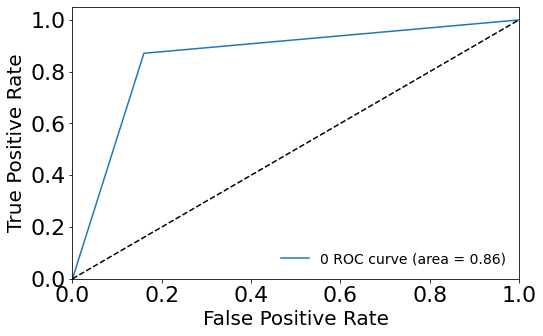

In [21]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(y_test)
lb.classes_.tolist()

fpr = dict()
tpr = dict()

roc_auc = dict()

by_test = lb.transform(y_test)
by_pred = lb.transform(y_pred)


for i in range(lb.classes_.size):
    fpr[i], tpr[i], _ = roc_curve(by_test[:,0], by_pred[:,0])
    roc_auc[i] = auc(fpr[i], tpr[i])

#roc_auc = roc_auc_score(by_test, by_pred, average=None)
roc_auc

plt.figure(figsize=(8, 5))
for i in range(lb.classes_.size-1):
    plt.plot(fpr[i], tpr[i], 
             label='%s ROC curve (area = %0.2f)' % (lb.classes_.tolist()[i], roc_auc[i]))
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=20)
plt.ylabel('True Positive Rate', fontsize=20) 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.legend(loc="lower right", fontsize=14, frameon=False)
plt.show()

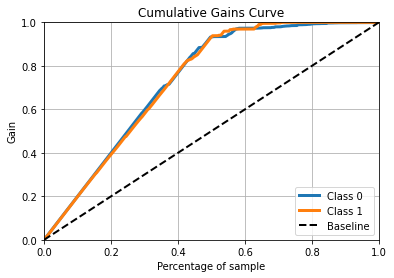

In [22]:
from sklearn.datasets import load_breast_cancer

from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB

#X, y = load_breast_cancer(return_X_y=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=100, stratify=y)

clf = CategoricalNB()
clf.fit(X_train, y_train)

predicted_probas = clf.predict_proba(X_test)

# The magic happens here

import matplotlib.pyplot as plt

import scikitplot as skplt

skplt.metrics.plot_cumulative_gain(y_test, predicted_probas)

plt.show()